In [1]:
from keystone.model import Net
from main import train
from types import SimpleNamespace

In [2]:
training_params = SimpleNamespace(
        file_path = './data/DKI_data/Ptest.csv',
        batch_size = 32,
        test_size = 0.0,
        lr = 0.001,
        epochs = 1000,
        verbosity = 10,
        layers = [100]
    )

In [3]:
train(training_params)

Epoch: 0 	Training Loss: 6.81e-06 	Validation Loss: nan
Epoch: 10 	Training Loss: 6.10e-08 	Validation Loss: nan
Epoch: 20 	Training Loss: 4.65e-08 	Validation Loss: nan
Epoch: 30 	Training Loss: 3.75e-08 	Validation Loss: nan
Epoch: 40 	Training Loss: 3.33e-08 	Validation Loss: nan
Epoch: 50 	Training Loss: 2.96e-08 	Validation Loss: nan
Epoch: 60 	Training Loss: 2.79e-08 	Validation Loss: nan
Epoch: 70 	Training Loss: 2.59e-08 	Validation Loss: nan
Epoch: 80 	Training Loss: 2.41e-08 	Validation Loss: nan
Epoch: 90 	Training Loss: 2.31e-08 	Validation Loss: nan
Epoch: 100 	Training Loss: 2.18e-08 	Validation Loss: nan
Epoch: 110 	Training Loss: 2.04e-08 	Validation Loss: nan
Epoch: 120 	Training Loss: 1.94e-08 	Validation Loss: nan
Epoch: 130 	Training Loss: 1.89e-08 	Validation Loss: nan
Epoch: 140 	Training Loss: 1.83e-08 	Validation Loss: nan
Epoch: 150 	Training Loss: 1.80e-08 	Validation Loss: nan
Epoch: 160 	Training Loss: 1.72e-08 	Validation Loss: nan
Epoch: 170 	Training Loss

KeyboardInterrupt: 

In [20]:
import torch

state_dict = torch.load('./models/simple_net.pt')

net = Net(100, 100, layers=[100, 100])

net.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Net:
	Missing key(s) in state_dict: "modules_list.1.weight", "modules_list.1.bias". 
	size mismatch for modules_list.0.weight: copying a param with shape torch.Size([1000, 1324]) from checkpoint, the shape in current model is torch.Size([100, 100]).
	size mismatch for modules_list.0.bias: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for modules_list.2.weight: copying a param with shape torch.Size([1324, 1000]) from checkpoint, the shape in current model is torch.Size([100, 100]).
	size mismatch for modules_list.2.bias: copying a param with shape torch.Size([1324]) from checkpoint, the shape in current model is torch.Size([100]).

In [7]:
from keystone.keystone import calculate_keystone_array

In [8]:
from keystone.data_loading import process_data

X, Y = process_data('./data/DKI_data/Ptrain.csv')
X.shape

(500, 100)

In [9]:
# send an example through the network
example = X[0]
example = torch.tensor(example).float()
example = example.unsqueeze(0)
out = net(example).detach().numpy()

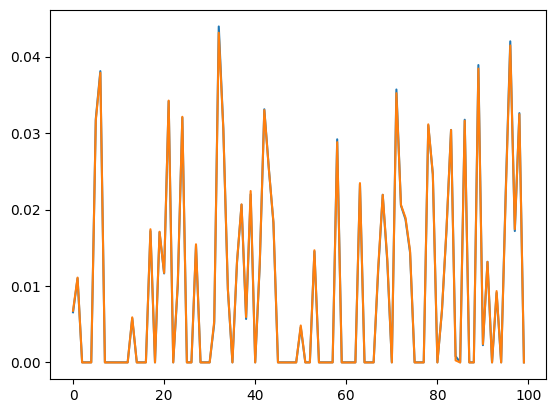

In [10]:
import matplotlib.pyplot as plt

plt.plot(out[0])
plt.plot(Y[0])

In [11]:
K = calculate_keystone_array(X, Y, net)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:01<00:00, 320.07it/s]


In [12]:
import numpy as np
DKI_keystone = np.genfromtxt('./data/DKI_data/keystoness_species.csv', delimiter=',')[1:,:]

<Axes: >

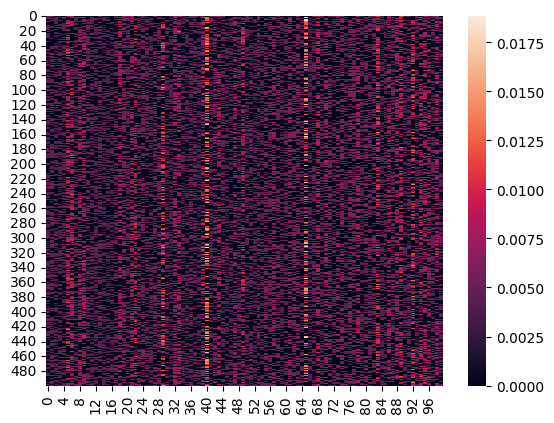

In [13]:
import seaborn as sns
sns.heatmap(K)


In [14]:
# get indices of all non-zero elements
import numpy as np
indices = np.where(K.T != 0)
indices

(array([ 0,  0,  0, ..., 99, 99, 99]),
 array([  0,   1,   2, ..., 494, 498, 499]))

In [15]:
# get only the non-zero elements of K and the corresponding indices in an array where each row is (i, j, K[i,j])
non_zero = np.array([(i+1, j+1, K.T[i,j]) for i, j in zip(indices[0], indices[1])])


In [11]:
# save as csv
np.savetxt('keystoness.csv', non_zero, delimiter=',', header='i,j,K[i,j]')

In [16]:
import pandas as pd
dataframe = pd.DataFrame(non_zero, columns=['i', 'j', 'K[i,j]'])
dataframe.tail(20)

,i,j,"K[i,j]"
24980,100.0,459.0,0.004372
24981,100.0,461.0,0.004510
24982,100.0,462.0,0.004428
24983,100.0,463.0,0.005486
24984,100.0,467.0,0.005459
24985,100.0,468.0,0.003785
24986,100.0,470.0,0.005185
24987,100.0,471.0,0.004993
24988,100.0,473.0,0.003902
24989,100.0,474.0,0.005553


In [14]:
#extract j column only
j = dataframe['j'].values
other_js = DKI_keystone[:,5]
other_js

array([  1.,   2.,   3., ..., 495., 499., 500.])

In [17]:
my_keystones = dataframe["K[i,j]"].values
pred_keystones = DKI_keystone[:,0]
true_keystones = DKI_keystone[:,2]

Text(0.5, 1.0, 'Ours')

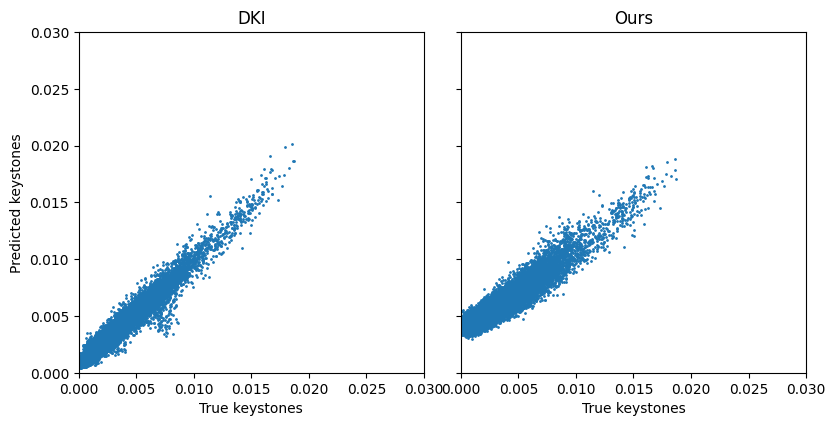

In [18]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2, sharey=True)
fig.tight_layout()
ax1.scatter(true_keystones, pred_keystones, s=1)
ax1.set_xlim(0,0.03)
ax1.set_ylim(0,0.03)
ax1.set_xlabel('True keystones')
ax1.set_ylabel('Predicted keystones')
ax1.set_title('DKI')

ax2.scatter(true_keystones, my_keystones, s=1)
ax2.set_xlim(0,0.03)
ax2.set_ylim(0,0.03)
ax2.set_xlabel('True keystones')
ax2.set_title('Ours')

In [36]:
DKI_keystone_pred = DKI_keystone[:,0]
DKI_keystone_true = DKI_keystone[:,2]

In [37]:
DKI_keystone_pred.shape

(25000,)

<Axes: >

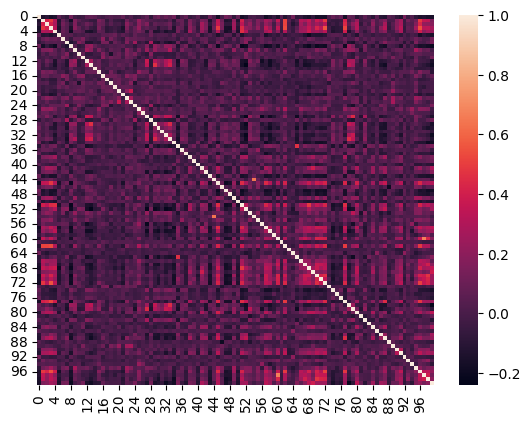

In [17]:
import seaborn as sns

sns.heatmap(data[:100,:100])